# Tugas Besar Sains Data dan Statistika - Problem 4
- Nama     : Faiq Muhammad Arif
- NIM      : 13620043
- Kelompok : 02


Note : Sebelum memulai program ini, unggah semua .zip flight-data ke folder /flight-data serta file airports.csv dan runways.csv yang telah didapatkan dari open dataset OurAirports.com (https://ourairports.com/data/) ke root folder runtime yang digunakan.

## Initialization

### Import Required Modules

In [70]:
import pandas as pd
import time
import glob
import os
import numpy as np
import matplotlib as plt
import concurrent.futures
import folium
import requests
import urllib.parse
from os import listdir
from os.path import join, isfile
from sklearn import neighbors
from sklearn import preprocessing

### Start Timers

In [71]:
time_processing = 0
time_detection = 0
time_validation = 0

## Data Processing

### Flight Dataset

#### Load Flight Data
Load the compressed CSV files in flight-data folder into a list of dataframes

In [72]:
start = time.time()

path = 'flight-data/'
file_path = [path+f for f in listdir(path) if isfile(join(path, f))]
file_path.sort()
filenames = [f.split('.')[0] for f in listdir(path) if isfile(join(path, f))]
filenames.sort()
dataframes_list = [pd.read_csv(filename) for filename in file_path]

for df, filename in zip(dataframes_list, filenames):
  df['filename'] = filename

end = time.time()
rel_time = end-start
time_processing += rel_time

#### Data Cleaning and Processing of Flight Dataset
This process will summarize the flight data into a dataframe containing the take off and landing coordinates and heading

In [73]:
start = time.time()

# Create Departure and Arrival dataframes
df_dep = pd.DataFrame()
df_arr = pd.DataFrame()
for df in dataframes_list:
    df.dropna(inplace=True) # Drop NaN values
    df.sort_values(by=['time_s'], inplace=True)
    df.reset_index(inplace = True, drop = True)
    #depart = df.groupby(np.arange(len(df))//10).mean()
    #df_dep = df_dep.append(depart)
    for i in df.index:
      if df['wow'][i] > 0 :
        df_dep = df_dep.append(df.iloc[i-1])
        break
    df2 = df.reindex(index=df.index[::-1])
    df2.reset_index(inplace = True, drop = True)
    for i in df2.index:
      if df2['wow'][i] > 0 :
        df_arr = df_arr.append(df2.iloc[i-1])
        break
      #if df['wow'][ind] > 0 :
        #df_arr = df_arr.append(df.iloc[ind])
        #break

df_deploc = df_dep[['filename','lat_rad','lon_rad','chi_rad']].copy()
df_deploc[['latitude_deg','longitude_deg','chi']] = df_deploc[['lat_rad','lon_rad','chi_rad']].apply(np.degrees)
df_deploc['chi'] %= 360
df_deploc.drop(['lat_rad','lon_rad','chi_rad'], axis=1, inplace=True)
df_deploc.sort_values(by=['filename'], inplace=True)
df_deploc.reset_index(inplace = True)
df_deploc
df_arrloc = df_arr[['filename','lat_rad','lon_rad','chi_rad']].copy()
df_arrloc[['latitude_deg','longitude_deg','chi']] = df_arrloc[['lat_rad','lon_rad','chi_rad']].apply(np.degrees)
df_arrloc['chi'] %= 360
df_arrloc.drop(['lat_rad','lon_rad','chi_rad'], axis=1, inplace=True)
df_arrloc.sort_values(by=['filename'], inplace=True)
df_arrloc.reset_index(inplace = True)

end = time.time()
rel_time = end-start
time_processing += rel_time
print(time_processing)

16.115888595581055


In [74]:
df_deploc.head()

,index,filename,latitude_deg,longitude_deg,chi
0,638,flight_10009,35.036792,-89.986643,359.060696
1,1219,flight_10013,35.024430,-89.984254,358.176323
2,1078,flight_10043,42.223396,-83.341991,28.904180
3,1390,flight_10049,42.222366,-83.373209,209.524685
4,2217,flight_10057,44.885007,-93.227280,121.455779


In [75]:
df_arrloc.head()

,index,filename,latitude_deg,longitude_deg,chi
0,381,flight_10009,36.275669,-94.302743,339.862652
1,367,flight_10013,37.250709,-93.395500,142.202850
2,590,flight_10043,41.070692,-73.709722,149.947986
3,334,flight_10049,41.534519,-93.655075,234.248695
4,229,flight_10057,41.306380,-95.893529,180.208541


In [76]:
dep_arr = [df_dep, df_arr]
for df in dep_arr:
  df = df[['filename','lat_rad','lon_rad','chi_rad']].copy()
  df[['latitude_deg','longitude_deg','chi']] = df[['lat_rad','lon_rad','chi_rad']].apply(np.degrees)
  df['chi'] %= 360
  df.drop(['lat_rad','lon_rad','chi_rad'], axis=1, inplace=True)
  df.sort_values(by=['filename'], inplace=True)
  df.reset_index(inplace = True, drop=True)


for df in dep_arr:
  display(df)

,time_s,hbaro_m,hdot_1_mps,hralt_m,lon_rad,lat_rad,tas_mps,gs_mps,wow,chi_rad,flap_te_pos,filename
638,1276.0,74.6760,5.60832,7.2390,-1.570563,0.611507,73.789987,72.793260,0.0,-0.016394,2.494,flight_10009
1219,2438.0,61.8744,9.18464,8.9916,-1.570522,0.611292,76.812322,76.844475,0.0,-0.031829,2.493,flight_10013
1078,2156.0,153.9240,2.19456,3.9624,-1.454592,0.736937,77.358915,73.307700,0.0,0.504473,2.493,flight_10043
1390,2780.0,147.2184,8.94080,11.3538,-1.455137,0.736919,76.458645,73.822140,0.0,-2.626290,2.493,flight_10049
2217,4434.0,264.2616,5.03936,4.9911,-1.627123,0.783391,76.715865,72.921870,0.0,2.119803,2.493,flight_10057
...,...,...,...,...,...,...,...,...,...,...,...,...
497,994.0,296.2656,4.06400,10.3632,-1.673559,0.721055,73.532768,70.799805,0.0,0.012271,2.477,flight_24318
648,1296.0,144.1704,4.30784,6.5151,-1.577059,0.676147,74.175817,72.150210,0.0,-1.012398,2.450,flight_30301
849,1698.0,346.8624,6.82752,9.4488,-1.673768,0.720974,75.043935,73.436310,0.0,2.517284,2.459,flight_33648
681,1362.0,314.2488,6.01472,6.2484,-1.673748,0.720899,74.368732,70.156755,0.0,2.523708,2.458,flight_36301


,time_s,hbaro_m,hdot_1_mps,hralt_m,lon_rad,lat_rad,tas_mps,gs_mps,wow,chi_rad,flap_te_pos,filename
381,6292.0,337.7184,0.40640,-0.2286,-1.645893,0.633130,55.463062,58.517550,0.0,-0.351463,3.717,flight_10009
367,7288.0,309.3720,0.00000,0.1905,-1.630059,0.650148,53.051625,53.887590,0.0,2.481908,3.700,flight_10013
590,11858.0,110.0328,0.00000,-0.1524,-1.286477,0.716819,55.302300,58.131720,0.0,2.617086,3.700,flight_10043
334,12050.0,264.8712,0.00000,-0.0762,-1.634589,0.724914,54.434182,57.617280,0.0,-2.194774,3.701,flight_10049
229,10668.0,295.3512,-0.08128,-0.1143,-1.673658,0.720932,55.559520,52.794405,0.0,-3.137953,3.701,flight_10057
...,...,...,...,...,...,...,...,...,...,...,...,...
803,7664.0,266.0904,0.97536,0.1905,-1.626790,0.783244,52.955168,51.251085,0.0,-1.026395,3.700,flight_24318
1575,10552.0,247.8024,1.86944,0.2286,-1.626794,0.783244,0.000000,48.871800,0.0,-1.017766,3.668,flight_30301
394,11242.0,60.6552,-0.08128,0.0762,-1.570557,0.611612,0.000000,48.421665,0.0,3.108904,3.680,flight_33648
760,12718.0,214.8840,2.51968,0.3048,-1.455065,0.736889,53.919742,53.115930,0.0,-2.640383,3.679,flight_36301


### Airport and Runway Dataset

#### Load Airport and Runway Data

In [77]:
start = time.time()

df_ap = pd.read_csv('airports.csv')
df_runw = pd.read_csv('runways.csv')

end = time.time()
rel_time = end-start
time_processing += rel_time

#### Data Cleaning and Processing of Airport Dataset

In [78]:
start = time.time()

all_airports = df_ap.copy()
df_ap = df_ap[df_ap["type"].str.contains("small_airport|heliport|closed|seaplane_base|balloonport") == False]
df_ap = df_ap[['ident','name','latitude_deg','longitude_deg']].copy()
df_ap.drop_duplicates(subset=['latitude_deg','longitude_deg'], inplace=True)
df_ap.dropna(inplace=True)

end = time.time()
rel_time = end-start
time_processing += rel_time

#### Data Cleaning and Processing of Runway Dataset

In [79]:
start = time.time()

runw_1 = df_runw[['airport_ident','le_ident','le_latitude_deg','le_longitude_deg', 'le_heading_degT']].copy()
runw_2 = df_runw[['airport_ident','he_ident','he_latitude_deg','he_longitude_deg', 'he_heading_degT']].copy()
runw_1.columns = ['airport_ident','ident','latitude_deg','longitude_deg', 'heading_degT']
runw_2.columns = ['airport_ident','ident','latitude_deg','longitude_deg', 'heading_degT']
runway = [runw_1, runw_2]
runw = pd.concat(runway)
all_runway = runw.copy()
runw.dropna(inplace=True)

end = time.time()
rel_time = end-start
time_processing += rel_time

### Processing Results Validation

#### Visualize Take Off and Landing Coordinates

,ident,name,latitude_deg,longitude_deg
6452,5A8,Aleknagik / New Airport,59.282600,-158.617996
11055,AF-0005,Khost International Airport,33.284605,69.807340
11091,AGGH,Honiara International Airport,-9.428000,160.054993
11096,AGGM,Munda Airport,-8.327970,157.263000
11119,AHJ,Hongyuan Airport,32.531540,102.352240
...,...,...,...,...
72080,ZYTN,Tonghua Sanyuanpu Airport,42.253889,125.703333
72081,ZYTX,Shenyang Taoxian International Airport,41.639801,123.483002
72083,ZYYJ,Yanji Chaoyangchuan Airport,42.882801,129.451004
72084,ZYYK,Yingkou Lanqi Airport,40.542524,122.358600


,airport_ident,ident,latitude_deg,longitude_deg,heading_degT
6,00CA,04,35.349300,-116.892998,50.0
50,00WI,09,44.304199,-89.052002,87.2
82,01LS,09,30.722700,-91.080200,92.2
91,01MT,13,48.794998,-114.886002,148.0
104,01OL,5,34.360722,-96.736473,50.0
...,...,...,...,...,...
43515,ZYMD,22,44.534599,129.576004,205.9
43516,ZYQQ,35,47.228802,123.925003,337.5
43518,ZYTL,28,38.964199,121.557999,275.6
43519,ZYTX,24,41.649300,123.498001,229.0


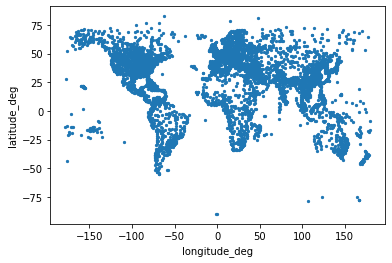

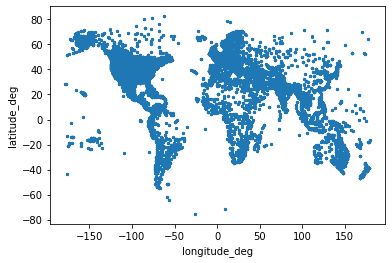

In [80]:
# display datasets
dep_arr = [df_ap, runw]

for df in dep_arr:
  display(df)
  df.plot.scatter(x='longitude_deg', y='latitude_deg', s=5)

## Airport and Runway Detection

### Create KNN Model

In [81]:
start = time.time()

X_airport = df_ap[[ 'latitude_deg', 'longitude_deg']]
y_airport_index = df_ap.index
X_runw = runw[[ 'latitude_deg', 'longitude_deg', 'heading_degT']]
y_runw_ident = runw['ident']
n_neighbors = 1
knn_airport_index = neighbors.KNeighborsClassifier(n_neighbors)
knn_airport_index.fit(X_airport,y_airport_index)
knn_runw_ident = neighbors.KNeighborsClassifier(n_neighbors)
knn_runw_ident.fit(X_runw,y_runw_ident)

end = time.time()
rel_time = end-start
time_detection += rel_time

### Detection

In [82]:
%%time
start = time.time()

departure_df = df_deploc[['latitude_deg','longitude_deg']].copy()
arrival_df = df_arrloc[['latitude_deg','longitude_deg']].copy()
departure_runw_df = df_deploc[['latitude_deg','longitude_deg', 'chi']].copy()
arrival_runw_df = df_arrloc[['latitude_deg','longitude_deg', 'chi']].copy()
summary = pd.DataFrame({'flight_data':filenames,
                                          'departure_airport_index':knn_airport_index.predict(departure_df),
                                          'departure_airport_icao':'',
                                          'departure_airport_name':'',
                                          'dep_lat':'',
                                          'dep_lon':'',
                                          'departure_runway':knn_runw_ident.predict(departure_runw_df),
                                          'arrival_airport_index':knn_airport_index.predict(arrival_df),
                                          'arrival_airport_icao':'',
                                          'arrival_airport_name':'',
                                          'arr_lat':'',
                                          'arr_lon':'',
                                          'arrival_runway':knn_runw_ident.predict(arrival_runw_df)})

summary['departure_airport_icao'] = summary['departure_airport_index'].map(df_ap['ident'])
summary['departure_airport_name'] = summary['departure_airport_index'].map(df_ap['name'])
summary['dep_lat'] = summary['departure_airport_index'].map(df_ap['latitude_deg'])
summary['dep_lon'] = summary['departure_airport_index'].map(df_ap['longitude_deg'])
summary['arrival_airport_icao'] = summary['arrival_airport_index'].map(df_ap['ident'])
summary['arrival_airport_name'] = summary['arrival_airport_index'].map(df_ap['name'])
summary['arr_lat'] = summary['arrival_airport_index'].map(df_ap['latitude_deg'])
summary['arr_lon'] = summary['arrival_airport_index'].map(df_ap['longitude_deg'])

end = time.time()
rel_time = end-start
time_detection += rel_time
display(summary)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- chi
Feature names seen at fit time, yet now missing:
- heading_degT

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- chi
Feature names seen at fit time, yet now missing:
- heading_degT

  warnings.warn(message, FutureWarning)


,flight_data,departure_airport_index,departure_airport_icao,departure_airport_name,dep_lat,dep_lon,departure_runway,arrival_airport_index,arrival_airport_icao,arrival_airport_name,arr_lat,arr_lon,arrival_runway
0,flight_10009,35521,KMEM,Memphis International Airport,35.042400,-89.976700,36L,37931,KXNA,Northwest Arkansas Regional Airport,36.281898,-94.306801,34
1,flight_10013,35521,KMEM,Memphis International Airport,35.042400,-89.976700,36L,37473,KSGF,Springfield Branson National Airport,37.245701,-93.388603,14
2,flight_10043,34100,KDTW,Detroit Metropolitan Wayne County Airport,42.212399,-83.353401,03L,35002,KHPN,Westchester County Airport,41.067001,-73.707603,16
3,flight_10049,34100,KDTW,Detroit Metropolitan Wayne County Airport,42.212399,-83.353401,22L,34093,KDSM,Des Moines International Airport,41.534000,-93.663101,23
4,flight_10057,35635,KMSP,Minneapolis–Saint Paul International Airport /...,44.882000,-93.221802,12R,35874,KOMA,Eppley Airfield,41.303200,-95.894096,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,flight_24318,35874,KOMA,Eppley Airfield,41.303200,-95.894096,18,35635,KMSP,Minneapolis–Saint Paul International Airport /...,44.882000,-93.221802,30L
349,flight_30301,37556,KSTL,St Louis Lambert International Airport,38.748697,-90.370003,30L,35635,KMSP,Minneapolis–Saint Paul International Airport /...,44.882000,-93.221802,30L
350,flight_33648,35874,KOMA,Eppley Airfield,41.303200,-95.894096,14L,35521,KMEM,Memphis International Airport,35.042400,-89.976700,18R
351,flight_36301,35874,KOMA,Eppley Airfield,41.303200,-95.894096,14L,34100,KDTW,Detroit Metropolitan Wayne County Airport,42.212399,-83.353401,22R


CPU times: user 76 ms, sys: 896 µs, total: 76.9 ms
Wall time: 74.2 ms


## Results Validation

### Visualization

In [83]:
start = time.time()

latmax_dep = df_deploc['latitude_deg'].max()
latmin_dep = df_deploc['latitude_deg'].min()
lonmax_dep = df_deploc['longitude_deg'].max()
lonmin_dep = df_deploc['longitude_deg'].min()
latmax_arr = df_arrloc['latitude_deg'].max()
latmin_arr = df_arrloc['latitude_deg'].min()
lonmax_arr = df_arrloc['longitude_deg'].max()
lonmin_arr = df_arrloc['longitude_deg'].min()
if latmax_dep >= latmax_arr:
  latmax = latmax_dep
else:
  latmax = latmax_arr
    
if latmin_dep <= latmin_arr:
  latmin = latmin_dep
else:
  latmin = latmin_arr

if lonmax_dep >= lonmax_arr:
  lonmax = lonmax_dep
else:
  lonmax = lonmax_arr

if lonmin_dep <= lonmin_arr:
  lonmin = lonmin_dep
else:
  lonmin = lonmin_arr

loc_map = float(latmin+(latmax-latmin)/2), float(lonmin+(lonmax+lonmin)/2)

m = folium.Map(location=loc_map)
m.fit_bounds([[latmin, lonmin], [latmax, lonmax]])

for i in summary.index:
  loc_dep = summary.loc[i,'dep_lat'],summary.loc[i,'dep_lon']
  loc_arr = summary.loc[i,'arr_lat'],summary.loc[i,'arr_lon']
  folium.Marker(loc_dep, popup=summary.loc[i,'departure_airport_name']).add_to(m)
  folium.Marker(loc_arr, popup=summary.loc[i,'arrival_airport_name'], icon=folium.Icon(color='red')).add_to(m)

end = time.time()
rel_time = end-start
time_validation += rel_time
m

### Airport Validation

In [84]:
%%time
start = time.time()

def search(loc):
  loc += ' Airport'
  url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(loc) +'?format=json&addressdetails=1&limit=1&polygon_svg=1'
  response = requests.get(url).json()
  return (float(response[0]["lat"]), float(response[0]["lon"]))

departure_pos_deg_dict = {}
key = summary['departure_airport_icao'].unique()
for i in range(len(key)):
  departure_pos_deg_dict[key[i]] = search(key[i])

arrival_pos_deg_dict = {}
key = summary['arrival_airport_icao'].unique()
for i in range(len(key)):
  arrival_pos_deg_dict[key[i]] = search(key[i])

end = time.time()
rel_time = end-start
time_validation += rel_time

['KMEM' 'KDTW' 'KMSP' 'KOKC' 'KOMA' 'KSTL']
[{'place_id': 283736000, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 11810372, 'boundingbox': ['35.0210106', '35.068969', '-89.9897419', '-89.9503656'], 'lat': '35.04625645', 'lon': '-89.97689466513185', 'display_name': 'Memphis International Airport, Winchester Road, Memphis, Shelby County, Tennessee, 38125, United States', 'class': 'aeroway', 'type': 'aerodrome', 'importance': 0.547828950833525, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/transport_airport2.p.20.png', 'address': {'aeroway': 'Memphis International Airport', 'road': 'Winchester Road', 'city': 'Memphis', 'county': 'Shelby County', 'state': 'Tennessee', 'ISO3166-2-lvl4': 'US-TN', 'postcode': '38125', 'country': 'United States', 'country_code': 'us'}, 'svg': 'M -89.9897419 -35.0578911 L -89.9897328 -35.057668 -89.9896562 -35.05743 -89.9893685 -35.0570341 -89.989295 -35.0569263 -89.9890532 -35

In [85]:
departure_pos_deg_dict

{'KDTW': (42.205699100000004, -83.35297537621658),
 'KMEM': (35.04625645, -89.97689466513185),
 'KMSP': (44.878019050000006, -93.2209280537696),
 'KOKC': (35.3848053, -97.60534425082406),
 'KOMA': (41.3011252, -95.88987091468039),
 'KSTL': (38.74962725, -90.37047024952082)}

In [86]:
arrival_pos_deg_dict

{'CYQR': (50.4309977, -104.66560618608906),
 'CYUL': (45.46873715, -73.74248664802043),
 'CYXE': (52.172371999999996, -106.69161089220799),
 'KATL': (33.63779875, -84.42927118585675),
 'KAUS': (30.19348925, -97.66500963529677),
 'KAZO': (42.2307865, -85.5510419237961),
 'KBGR': (44.8072619, -68.81941486105113),
 'KBHM': (33.5635078, -86.75154126864663),
 'KBNA': (36.11958985, -86.68308703291842),
 'KBTR': (30.5319743, -91.15042415051039),
 'KBTV': (44.472896500000004, -73.15146310750751),
 'KCHS': (32.89929845, -80.03946503050427),
 'KCID': (41.8855638, -91.71473063913916),
 'KCLE': (41.406618550000005, -81.85120214358412),
 'KCLT': (35.21074145, -80.9457435226013),
 'KCVG': (39.049907149999996, -84.66516172504984),
 'KDAY': (39.905318699999995, -84.22024542480268),
 'KDFW': (32.89651945, -97.0465220537124),
 'KDLH': (46.84183845, -92.20329684929376),
 'KDSM': (41.534549299999995, -93.65923944589736),
 'KDTW': (42.205699100000004, -83.35297537621658),
 'KEWR': (40.68906405, -74.1772548

In [87]:
for code, coor in departure_pos_deg_dict.items():
  print(coor)

(35.04625645, -89.97689466513185)
(42.205699100000004, -83.35297537621658)
(44.878019050000006, -93.2209280537696)
(35.3848053, -97.60534425082406)
(41.3011252, -95.88987091468039)
(38.74962725, -90.37047024952082)


#### Departure Airport

In [88]:
start = time.time()

m_valdep = folium.Map(location=loc_map)
m_valdep.fit_bounds([[latmin, lonmin], [latmax, lonmax]])

for code, coor in departure_pos_deg_dict.items():
  folium.Marker(coor, popup=code, icon=folium.Icon(color='green')).add_to(m_valdep)

for i in summary.index:
  loc_dep = summary.loc[i,'dep_lat'],summary.loc[i,'dep_lon']
  loc_arr = summary.loc[i,'arr_lat'],summary.loc[i,'arr_lon']
  folium.Marker(loc_dep, popup=summary.loc[i,'departure_airport_name']).add_to(m_valdep)
  #folium.Marker(loc_arr, popup=summary.loc[i,'arrival_airport_name'], icon=folium.Icon(color='red')).add_to(m_val)

end = time.time()
rel_time = end-start
time_validation += rel_time
m_valdep

#### Arrival Airport

In [89]:
start = time.time()

m_valarr = folium.Map(location=loc_map)
m_valarr.fit_bounds([[latmin, lonmin], [latmax, lonmax]])

for code, coor in arrival_pos_deg_dict.items():
  folium.Marker(coor, popup=code, icon=folium.Icon(color='green')).add_to(m_valarr)

for i in summary.index:
  loc_arr = summary.loc[i,'arr_lat'],summary.loc[i,'arr_lon']
  folium.Marker(loc_arr, popup=summary.loc[i,'arrival_airport_name'], icon=folium.Icon(color='red')).add_to(m_valarr)

end = time.time()
rel_time = end-start
time_validation += rel_time
m_valarr

## Execution Time

In [90]:
print('Data Processing Execution Time:', time_processing, 's')
print('Airport and Runway Detection Execution Time:', time_detection, 's')
print('Validation Time:', time_validation, 's')
print('Total Execution Time:', time_processing + time_detection + time_validation, 's')

Data Processing Execution Time: 16.608456134796143 s
Airport and Runway Detection Execution Time: 0.12739133834838867 s
Validation Time: 32.627381801605225 s
Total Execution Time: 49.363229274749756 s


## Export Results to Excel

In [91]:
results = summary[['flight_data','departure_airport_icao','departure_airport_name','departure_runway', 'arrival_airport_icao', 'arrival_airport_name', 'arrival_runway']].copy()
results.columns = ['Flight Data', 'Departure Airport (ICAO Code)', 'Departure Airport', 'Departure Runway', 'Arrival Airport (ICAO Code)', 'Arrival Airport', 'Arrival Runway']
results.to_excel("results.xlsx")

## System Info

In [92]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b